In [ ]:
!pip install transformers sentence-transformers bertopic safetensors > /dev/null

In [ ]:
from sentence_transformers import SentenceTransformer

embed_minilm = SentenceTransformer("all-MiniLM-L12-v2")

In [ ]:
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='all',  remove=('headers',
                                                 'footers',
                                                 'quotes'))['data']

In [ ]:
len(docs)

18846

In [ ]:
from huggingface_hub import login
login()

In [ ]:
# function to do the embedding and upload the data to hub
from sentence_transformers import SentenceTransformer
import pickle

def embed_data(data, batch_size,save_pkl=False):
  """Takes in the data and the batch_size.
  It returns the embedding back."""

  embed_minilm = SentenceTransformer("all-MiniLM-L12-v2")
  docs_embed = embed_minilm.encode(data,
                                   batch_size=batch_size,
                                   show_progress_bar=True)
  if not save_pkl:
    return docs_embed

  else:
    fileName = input('Enter file name for embeddings: ')
    fileName = f"{fileName}.pkl"
    with open(fileName, 'wb') as fin:
      pickle.dump({'sentences':data,
                   'embeddings':docs_embed},
                  fin,
                  protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Embeddings written to {fileName}")


In [ ]:
embed_100 = embed_data(docs[:100],batch_size=10)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
embed_5000 = embed_data(docs[:5000],
                        batch_size=10,save_pkl=True)

Batches:   0%|          | 0/500 [00:00<?, ?it/s]

Enter file name for embeddings: embed_5000
Embeddings written to embed_5000.pkl


In [ ]:
embed_all = embed_data(docs,
                        batch_size=60,
                        save_pkl=True)

Batches:   0%|          | 0/315 [00:00<?, ?it/s]

Enter file name for embeddings: embeddingall
Embeddings written to embeddingall.pkl
Embeddings written to embeddingall.pkl


In [ ]:
embed_data(docs[:100],batch_size=50,save_pkl=True)

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Enter file name for embeddings: trial_embedding
Embeddings written to trial_embedding.pkl


In [ ]:
def load_embeding(embed_pkl):
  with open(embed_pkl,'rb') as fin:
    file_embeds = pickle.load(file=fin,fix_imports=True)
  return file_embeds

In [ ]:
docs_embed = load_embeding("trial_embedding.pkl")

In [ ]:
!wget https://raw.githubusercontent.com/insightbuilder/python_de_learners_data/main/code_script_notebooks/projects/huggingface_AWS/yelp.csv

--2023-06-17 10:04:11--  https://raw.githubusercontent.com/insightbuilder/python_de_learners_data/main/code_script_notebooks/projects/huggingface_AWS/yelp.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8091185 (7.7M) [text/plain]
Saving to: ‘yelp.csv’

yelp.csv            100%[===================>]   7.72M  --.-KB/s    in 0.09s   

2023-06-17 10:04:12 (84.8 MB/s) - ‘yelp.csv’ saved [8091185/8091185]



In [1]:
import pandas as pd

yelp_reviews = pd.read_csv('yelp.csv')
yelp_reviews.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [ ]:
text_review = yelp_reviews['text'].to_list()

In [ ]:
len(text_review)

10000

In [ ]:
from bertopic import BERTopic

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# we add this to remove stopwords
vectorizer_model = CountVectorizer(ngram_range=(1, 2),
                                   stop_words="english")

model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', calculate_probabilities=True,
    verbose=True
)
topics, probs = model.fit_transform(text_review)


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2023-06-17 10:14:46,148 - BERTopic - Transformed documents to Embeddings
2023-06-17 10:15:10,080 - BERTopic - Reduced dimensionality
2023-06-17 10:15:19,219 - BERTopic - Clustered reduced embeddings


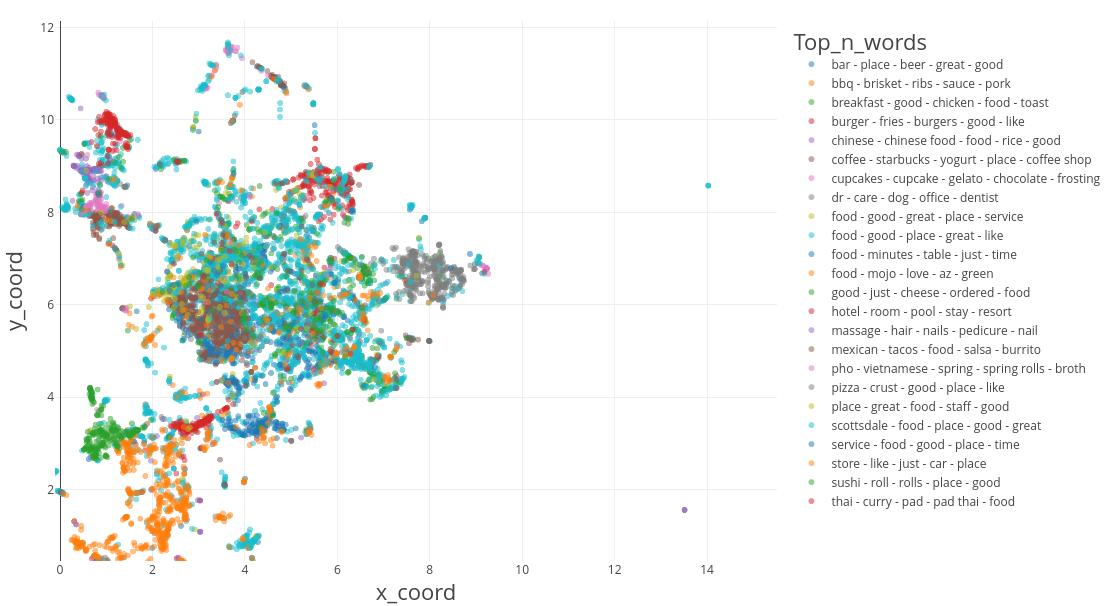

In [ ]:
embed_model = 'sentence-transformers/all-MiniLM-L6-v2'

model.push_to_hf_hub(
    repo_id='Kamaljp/yelpreview_base',
    save_ctfidf=True,
    save_embedding_model=embed_model,
    serialization='pytorch'
)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

topic_embeddings.bin:   0%|          | 0.00/37.7k [00:00<?, ?B/s]

ctfidf.bin:   0%|          | 0.00/10.9M [00:00<?, ?B/s]

'https://huggingface.co/Kamaljp/yelpreview_base/tree/main/'

In [ ]:
topic_freq = model.get_topic_info()

topic_freq.head(5)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3661,-1_food_good_place_great,"[food, good, place, great, just, like, service...",[Bottom line: the new owners bring you better ...
1,0,675,0_mexican_tacos_salsa_burrito,"[mexican, tacos, salsa, burrito, mexican food,...",[I find it hilarious that someone would refere...
2,1,406,1_pizza_crust_pizzas_good,"[pizza, crust, pizzas, good, bianco, wait, pla...",[I came here on a strong recommendation from a...
3,2,294,2_burger_fries_burgers_good,"[burger, fries, burgers, good, bun, like, swee...",[I'm sorry to be what seems to be the lone one...
4,3,271,3_bar_music_drinks_night,"[bar, music, drinks, night, place, crowd, peop...","[in honor of the impending superbowl XLV, i wa..."


In [ ]:
doc_info = model.get_document_info(text_review)

doc_info.columns

Index(['Document', 'Topic', 'Name', 'Representation', 'Representative_Docs',
       'Top_n_words', 'Probability', 'Representative_document'],
      dtype='object')

In [ ]:
doc_info.shape

(10000, 8)

In [ ]:
doc_info.head(2)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,My wife took me here on my birthday for breakf...,-1,-1_food_good_place_great,"[food, good, place, great, just, like, service...",[Bottom line: the new owners bring you better ...,food - good - place - great - just - like - se...,0.608068,False
1,I have no idea why some people give bad review...,1,1_pizza_crust_pizzas_good,"[pizza, crust, pizzas, good, bianco, wait, pla...",[I came here on a strong recommendation from a...,pizza - crust - pizzas - good - bianco - wait ...,0.308370,False


In [ ]:
model.visualize_topics()

In [ ]:
model.visualize_hierarchy()

In [ ]:
model.visualize_barchart()

In [ ]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
umap_model = UMAP(n_neighbors=3,
                  n_components=3,
                  min_dist=0.05)
hdbscan_model = HDBSCAN(min_cluster_size=80, min_samples=40,
                        gen_min_span_tree=True,
                        prediction_data=True)

In [ ]:
umap_model.transform([embedding_model.encode(text_review[0])])

array([[5.3992805, 6.423642 , 4.822698 ]], dtype=float32)

In [ ]:
umap_model.transform([embedding_model.encode(text_review[0])])[0][0]

5.412464

In [ ]:
model_custom = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=5,
    language='english',
    calculate_probabilities=True,
    verbose=True
)
topics, probs = model_custom.fit_transform(text_review)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2023-06-17 10:19:35,414 - BERTopic - Transformed documents to Embeddings
2023-06-17 10:19:45,377 - BERTopic - Reduced dimensionality
2023-06-17 10:19:46,620 - BERTopic - Clustered reduced embeddings


In [ ]:
model_custom.push_to_hf_hub(
    repo_id='Kamaljp/yelpreview_custom',
    save_ctfidf=True,
    save_embedding_model=embed_model,
    serialization='pytorch'
)

ctfidf.bin:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

ctfidf_config.json:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

topic_embeddings.bin:   0%|          | 0.00/37.7k [00:00<?, ?B/s]

'https://huggingface.co/Kamaljp/yelpreview_custom/tree/main/'

In [ ]:
model_custom.get_topic_info(topic=5)

,Topic,Count,Name,Representation,Representative_Docs
0,1,1240,1_place_bar_great_good,"[place, bar, great, good, food]",[I frequent RnR quite a bit for happy hour. I...


In [ ]:
model_custom.visualize_barchart()

In [ ]:
model_custom.visualize_hierarchy()

In [ ]:
docs_data = model_custom.get_document_info(text_review)
docs_data.head(2)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,My wife took me here on my birthday for breakf...,7,7_breakfast_good_chicken_food,"[breakfast, good, chicken, food, toast]",[I went during the week with my two young chil...,breakfast - good - chicken - food - toast,1.000000,False
1,I have no idea why some people give bad review...,3,3_pizza_crust_good_place,"[pizza, crust, good, place, like]","[Best pizza place ever!!!!!!!!!!!!!!, I came h...",pizza - crust - good - place - like,0.292365,False


In [ ]:
review_embeds = embedding_model.encode(text_review,
                                       batch_size=64)

In [ ]:
review_umap = umap_model.transform(review_embeds)

In [ ]:
len(review_umap[:])

10000

In [ ]:
docs_data.loc[:,'x_coord'] = [coord[0] for coord in review_umap]
docs_data.loc[:,'y_coord'] = [coord[1] for coord in review_umap]
docs_data.loc[:,'z_coord'] = [coord[2] for coord in review_umap]
docs_data.loc[:,'point_size'] = [abs(round(coord[0],0)) for coord in review_umap]

In [ ]:
docs_data.to_csv("docs_with_umap.csv",index=False)

In [2]:
docs_data = pd.read_csv("/home/solverbot/Downloads/docs_with_umap(1).csv")

In [3]:
yelp_reviews.loc[:,'x_coord'] = docs_data.loc[:,"x_coord"]
yelp_reviews.loc[:,'y_coord'] = docs_data.loc[:,"y_coord"]
yelp_reviews.loc[:,'z_coord'] = docs_data.loc[:,"z_coord"]

In [4]:
yelp_reviews.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,x_coord,y_coord,z_coord
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,5.400474,6.407872,4.811073
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,7.710525,6.344959,7.351152


In [6]:
yelp_reviews.to_csv("yelpReviews_umapCoords.csv",index=False)

In [ ]:
docs_data.head(2)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,x_coord,y_coord,z_coord,point_size
0,My wife took me here on my birthday for breakf...,7,7_breakfast_good_chicken_food,"[breakfast, good, chicken, food, toast]",[I went during the week with my two young chil...,breakfast - good - chicken - food - toast,1.000000,False,5.400474,6.407872,4.811073,5.0
1,I have no idea why some people give bad review...,3,3_pizza_crust_good_place,"[pizza, crust, good, place, like]","[Best pizza place ever!!!!!!!!!!!!!!, I came h...",pizza - crust - good - place - like,0.292365,False,7.710525,6.344959,7.351152,8.0


In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter_3d(docs_data[docs_data.Topic.isin([0,1,2])],
                    x='x_coord',
                    y='y_coord',
                    z='z_coord',
                    color='Topic',
                    opacity=0.7,
                    size='point_size')

In [ ]:
fig.update_traces(marker=dict(line=dict(width=0.1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

In [ ]:
from bertopic.representation import KeyBERTInspired

# Fine-tune your topic representations
representation_model = KeyBERTInspired()

model_repKB = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    top_n_words=5,
    language='english',
    calculate_probabilities=True,
    verbose=True
)
topics, probs = model_repKB.fit_transform(text_review)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2023-06-17 10:20:58,146 - BERTopic - Transformed documents to Embeddings
2023-06-17 10:21:08,245 - BERTopic - Reduced dimensionality
2023-06-17 10:21:09,312 - BERTopic - Clustered reduced embeddings


In [ ]:
model_repKB.push_to_hf_hub(
    repo_id='Kamaljp/yelpreview_repKB',
    save_ctfidf=True,
    save_embedding_model=embed_model,
    serialization='pytorch'
)

ctfidf.bin:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

ctfidf_config.json:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

topic_embeddings.bin:   0%|          | 0.00/33.1k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

'https://huggingface.co/Kamaljp/yelpreview_repKB/tree/main/'

In [ ]:
model_repKB.visualize_barchart()

In [ ]:
model_repKB.visualize_hierarchy()

In [ ]:
topic_data = model_repKB.get_topic_info()

In [ ]:
topic_data.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1322,-1_restaurant_delicious_food_sandwich,"[restaurant, delicious, food, sandwich, chicken]",[Ive been to F&H on numerous occasions. The ni...
1,0,4668,0_restaurant_burger_lunch_meal,"[restaurant, burger, lunch, meal, pizza]",[I think all the 5 star reviews are from peopl...
2,1,723,1_mexican food_tacos_taco_chips salsa,"[mexican food, tacos, taco, chips salsa, salsa]",[I went here with my husband last Sunday after...
3,2,561,2_thai food_chinese food_fried rice_thai,"[thai food, chinese food, fried rice, thai, pa...",[Had lunch here today after hearing all the co...
4,3,483,3_scottsdale_restaurant_phoenix_dinner,"[scottsdale, restaurant, phoenix, dinner, ariz...",[I'm going to have to work through this review...


In [ ]:
labels = model_repKB.generate_topic_labels()

In [ ]:
labels

['-1_restaurant_bbq_meal',
 '0_great food_good food_food great',
 '1_mexican food_burrito_salsa',
 '2_shop_shopping_store',
 '3_beer selection_beers_drinks',
 '4_restaurant_appetizer_meal',
 '5_best pizza_pizza good_good pizza',
 '6_restaurant_bbq_wines',
 '7_good burger_burger_burger fries',
 '8_best sushi_sushi_sushi bar',
 '9_better starbucks_coffee_starbucks',
 '10_manicure_gel manicure_nail',
 '11_chinese food_chinese restaurant_fried rice',
 '12_restaurant_dinner_waiter',
 '13_hotels_hotel_resort',
 '14_ice cream_flavors_flavor',
 '15_thai food_thai restaurant_pad thai',
 '16_breakfast food_breakfast_pancakes',
 '17_movie theater_theaters_theater',
 '18_vietnamese cuisine_vietnamese restaurants_vietnamese restaurant',
 '19_sandwich great_sandwiches good_sandwich shop']

In [ ]:
model_repKB.c_tf_idf_

<21x432278 sparse matrix of type '<class 'numpy.float64'>'
	with 613010 stored elements in Compressed Sparse Row format>

steps to get topics:

- Embedding documents

- Reducing dimensionality of embeddings (Uniform Manifold Approximation & Production)

- Clustering reduced embeddings into topics

- Tokenization of topics

- Weight tokens

- Represent topics with one or multiple representations

In [ ]:
topic_model.find_topics("windows")

In [ ]:
topic_model.save("topic_model",serialization='safetensors')

In [ ]:
topic_reps = topic_model.topic_representations_
topic_reps

In [ ]:
topic_ctfidf = topic_model.c_tf_idf_
topic_ctfidf

<30x62308 sparse matrix of type '<class 'numpy.float64'>'
	with 137936 stored elements in Compressed Sparse Row format>

In [ ]:
topic_embedding = topic_model.topic_embeddings_
topic_embedding

In [ ]:
topic_distr, _ = topic_model.approximate_distribution(docs[:5000])

100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


In [ ]:
topic_model.visualize_distribution(topic_distr[1])

In [ ]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(docs[1], topic_token_distr[1])
df

100%|██████████| 19/19 [01:18<00:00,  4.11s/it]


,My,brother,is,in,the,market,for,high,performance,video,card,that,supports,VESA,local,bus,with,2MB,RAM,Does,anyone,have,suggestions,ideas,on,Diamond,Stealth,Pro,Local,Bus,Orchid,Farenheit,1280,ATI,Graphics,Ultra,Pro,Any,other,high,performance,VLB,card,Please,post,or,email,Thank,you,Matt
5_card_monitor_video_drivers,0.000,0.000,0.000,0.000,0.000,0.000,0.161,0.433,0.733,1.012,1.015,0.743,0.443,0.164,0.000,0.000,0.000,0.000,0.123,0.225,0.225,0.225,0.102,0.000,0.000,0.105,0.105,0.105,0.105,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.107,0.322,0.549,0.773,0.901,0.685,0.459,0.234,0.000,0.000,0.000,0.000
9_mhz_cpu_speed_motherboard,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.114,0.114,0.114,0.114,0.000,0.000,0.000,0.000,0.000,0.000,0.115,0.115,0.115,0.115,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
10_jim_you_context_your,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.114,0.242,0.345,0.345,0.230,0.103,0.000,0.000
16_windows_memory_problem_running,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.128,0.128,0.128,0.128,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
18_address_mail_me_email,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.108,0.293,0.459,0.627,0.632,0.447,0.281,0.113
28_shipping_bid_sell_cdtv,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.102,0.102,0.102,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
44_os_mac_ibm_32,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.111,0.111,0.111,0.111,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
56_simms_jh_memory_70ns,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.110,0.110,0.110,0.110,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
67_isa_bus_eisa_ide,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.219,0.470,0.691,0.887,0.668,0.417,0.196,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.190,0.374,0.523,0.645,0.455,0.271,0.122,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
70_anyone_itll_dean_place,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.108,0.108,0.108,0.108,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.128,0.128,0.128,0.128,0.000,0.000,0.000


## Online Topic Modeling

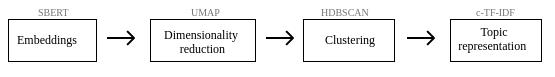

In [ ]:
doc_chunks = [docs[5000:i+1000] for i in range(5000, len(docs), 1000)]

In [ ]:
doc_chunks[2]

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
from bertopic.vectorizers import OnlineCountVectorizer

# Prepare sub-models that support online learning
umap_model = IncrementalPCA(n_components=5)
cluster_model = MiniBatchKMeans(n_clusters=50, random_state=0)
vectorizer_model = OnlineCountVectorizer(stop_words="english", decay=.01)

In [ ]:
from bertopic import BERTopic

topic_model_ol = BERTopic(umap_model=umap_model,
                       hdbscan_model=cluster_model,
                       vectorizer_model=vectorizer_model)

# Incrementally fit the topic model by training on 1000 documents at a time
for docs in doc_chunks:
    topic_model_ol.partial_fit(docs)

## Semi Supervised

In [ ]:
data = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))

docs = data["data"]
categories = data["target"]
category_names = data["target_names"]

In [ ]:
#Initiating the topic modeling with categories
topic_model_ss = BERTopic(verbose=True).fit(docs[:100], y=category_names)